In [ ]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as Drawgeo
import matplotlib.pyplot as plt
import numpy as np

p = 5
mesh = Mesh(unit_cube.GenerateMesh(maxh=0.05))
fes = HCurl(mesh, order=p, dirichlet="left|bottom|back",
         wb_withedges=False)
print("NDOF = ", fes.ndof)
u,v = fes.TnT()
a = BilinearForm(fes)
a += curl(u)*curl(v)*dx
f = LinearForm(fes)
#f += v*dx

with TaskManager():
    pre = Preconditioner(a, "bddc", coarsetype="h1amg")
    a.Assemble()
    f.Assemble()

    gfu = GridFunction(fes)
    solvers.CG(mat=a.mat, rhs=f.vec, sol=gfu.vec,
               pre=pre, maxsteps=500)
Draw(gfu)



NDOF =  3622374


## Exact Solution:
Solving for E then converting to H via Faraday's law

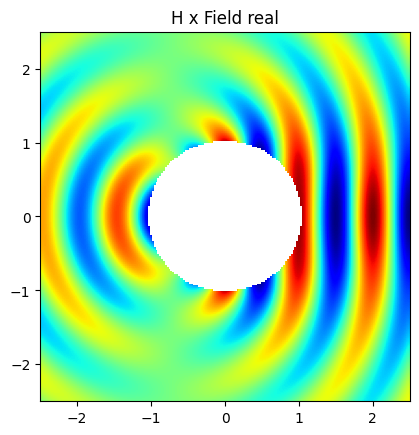

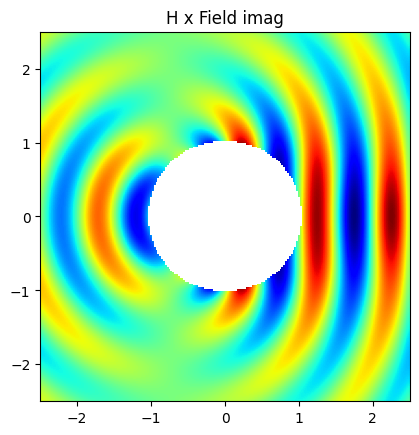

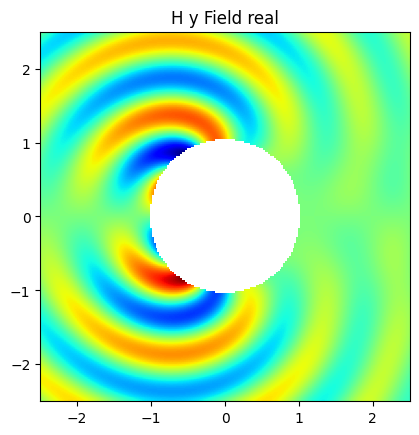

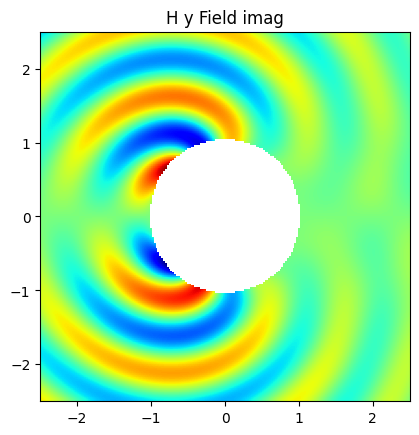

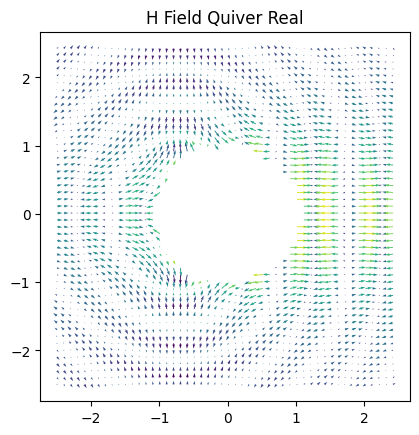

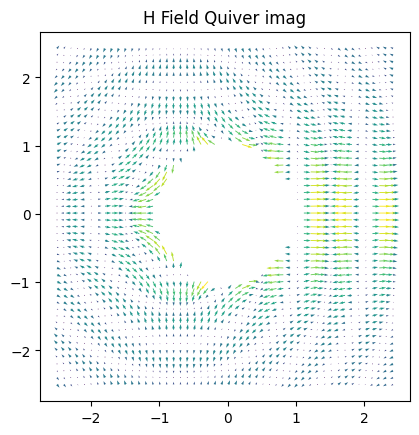

In [2]:
from scipy.special import jv as besselj
from scipy.special import yv as bessely
from scipy.special import hankel1, hankel2
import numpy as np
from matplotlib import pyplot as plt

omega = 2*np.pi

x_extent = np.linspace(-2.5, 2.5, 200)
y_extent = x_extent
xx,yy = np.meshgrid(x_extent, y_extent)

R = np.sqrt(xx**2 + yy**2)
theta = np.arctan2(yy, xx)


mask = np.ones(xx.shape)
for yind, yval in enumerate(yy):
    for xind, xval in enumerate(xx):
        if R[xind, yind] < 1:
            mask[xind, yind] = np.nan

zz = np.zeros(xx.shape)

TE = False
if TE is True:
# TE
    for n in range(30):
        dj=(-besselj(n-1,omega)+besselj(n+1,omega))/2
        dy=(-bessely(n-1,omega)+bessely(n+1,omega))/2
        dh=dj-1j*dy;

        z=omega*R;
        bj=besselj(n,z);
        by=bessely(n,z);
        h=bj-1j*by;
        if n==0:
            zz=zz-(dj/dh)*h*np.cos(n*theta)*(1j**(-n)) * mask
        else:
            zz=zz-2*(dj/dh)*h*np.cos(theta*n)*(1j**(-n)) * mask
            
else:
    for n in range(30):
        if n == 0:
            epsilon_n = 1
        else:
            epsilon_n = 2
        
        # for cylinder radius r=1
        
        jv_over_h2 = besselj(n, omega*1)/hankel1(n, omega*1)
        zz = zz -(1j)**n * epsilon_n * jv_over_h2 * hankel1(n, omega * R) * np.cos(theta*n) * mask
        
        #zz = np.conj(zz) # Don't know why this needs a conjugate. Probably something to do with the direction of the wave Balanis assumed.

E = np.asarray([np.zeros(zz.shape), np.zeros(zz.shape), zz])
E_x = E[0,:,:]
E_y = E[1,:,:]
E_z = E[2,:,:]

curlE = np.asarray([np.gradient(E_z, axis=1) , -np.gradient(E_z, axis=0) , np.zeros(zz.shape)])
H = (-1 / (1j*omega)) * curlE
plt.figure()
plt.title('H x Field real')
plt.imshow(H[0,:,:].real, cmap='jet', extent=[-2.5,2.5, -2.5, 2.5])

plt.figure()
plt.title('H x Field imag')
plt.imshow(H[0,:,:].imag, cmap='jet', extent=[-2.5,2.5, -2.5, 2.5])

plt.figure()
plt.title('H y Field real')
plt.imshow(H[1,:,:].real, cmap='jet', extent=[-2.5,2.5, -2.5, 2.5])

plt.figure()
plt.title('H y Field imag')
plt.imshow(H[1,:,:].imag, cmap='jet', extent=[-2.5,2.5, -2.5, 2.5])

plt.figure()
plt.title('H Field Quiver Real')
plt.quiver(xx[0::4, 0::4], yy[0::4,0::4], H[0,0::4,0::4].real, H[1,0::4,0::4].real, np.sqrt(H[0,0::4,0::4].real**2 + H[1,0::4,0::4].imag**2))
ax = plt.gca()
#get x and y limits
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
#set aspect ratio
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high)))

plt.figure()
plt.title('H Field Quiver imag')
plt.quiver(xx[0::4, 0::4], yy[0::4,0::4], H[0,0::4,0::4].imag, H[1,0::4,0::4].imag, np.sqrt(H[0,0::4,0::4].imag**2 + H[1,0::4,0::4].imag**2))
ax = plt.gca()
#get x and y limits
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
#set aspect ratio
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high)))


## Generating Mesh

In [3]:
def generate_mesh(h, inner_rect_size, PML_size):
    
    inner_rect=WorkPlane().RectangleC(inner_rect_size,inner_rect_size).Face()
    scatterer = WorkPlane().Circle(0,0,1).Face()

    inner_rect.edges.name = 'innerbnd'
    scatterer.edges.name = 'scabnd'

    inner = inner_rect - scatterer

    #Drawgeo(inner)

    wp2=WorkPlane().RectangleC(inner_rect_size+inner_rect_size,inner_rect_size+inner_rect_size).RectangleC(inner_rect_size,inner_rect_size).Reverse()
    outer = wp2.Face()

    outer.edges.name = 'outerbnd'
    #inner.edges.name = 'innerbnd'
    inner.faces.name ='inner'
    outer.faces.name = 'pmlregion'

    #Drawgeo(Glue([outer,inner]))

    geo = OCCGeometry(Glue([inner, outer]), dim=2)
    mesh = Mesh(geo.GenerateMesh (maxh=h))
    mesh.Curve(5)
    return mesh

inner_rect_size = 10
PML_size = 5
h = 0.3
mesh = generate_mesh(h, inner_rect_size, PML_size)
Draw(mesh)




WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [27]:
K = CF((2*np.pi, 0))
phasor = exp(1j * ((K[0] * x) + (K[1] * y)))
ex = 1 * phasor
ey = 1 * phasor
ez =  CF((ex, ey))
Draw(ez, mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

## Without PML:

In [28]:
fes = HCurl(mesh, order=4, complex=True, dirichlet='scabnd')
u = fes.TrialFunction()
v = fes.TestFunction()

omega = sqrt(K[0]**2 + K[1]**2)

a = BilinearForm(fes, symmetric=True)
a += curl(u)*curl(v)*dx - omega**2*u*v*dx
a += -1j * omega * u.Trace() * v.Trace() * ds('outerbnd')
a.Assemble()

scat = GridFunction(fes)
scat.Set(ez, BND)

b = LinearForm(fes)
b += Cross(specialcf.normal, curl(scat)) * v * ds('scabnd')

b.Assemble()

scat = GridFunction(fes)
#scat.Set(-ez, BND)

r = b.vec - a.mat * scat.vec
scat.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs()) * r

Draw(scat, mesh)
Draw(ez, mesh)
Draw(scat - ez, mesh)

TypeError: Cross(): incompatible function arguments. The following argument types are supported:
    1. (arg0: ngsolve.fem.CoefficientFunction, arg1: ngsolve.fem.CoefficientFunction) -> ngsolve.fem.CoefficientFunction

Invoked with: <bound method PyCapsule.normal of <ngsolve.fem.SpecialCFCreator object at 0x7f93ac0aa430>>, <ngsolve.comp.GridFunctionCoefficientFunction object at 0x7f92c3e68450>

## With PML

In [6]:
def absval(x):
    return sqrt(x**2)

d = inner_rect_size
z_x = IfPos(absval(x) - d/2, x + (1j * ( absval(x) - d)/0.5) * x, x) # returns z_j if |x|>2.5 else returns x
z_y = IfPos(absval(y) - d/2, y + (1j * ( absval(y) - d)/0.5) * y, y) # returns z_j if |y|>2.5 else returns y

#Draw(z_x.imag, mesh)
#Draw(z_y.imag, mesh)

In [7]:
dzx = z_x.Diff(x)
dzy = z_y.Diff(y)

#Draw(dzx.imag, mesh)
#Draw(dzy.imag, mesh)

dz_tot = dzx * dzy
#Draw(dz_tot.imag,mesh)

In [8]:
Z = CF((dz_tot / (dzx**2), dz_tot / (dzy**2)))
#Z = CF((1,1))
#dz_tot = 1



def With_PML(mesh, p, K, ez, Z, dz_tot):

    fes = HCurl(mesh, order=p, complex=True, dirichlet='scabnd')
    u = fes.TrialFunction()
    v = fes.TestFunction()

    omega = sqrt(K[0]**2 + K[1]**2)

    #inner = CF( Z[0] * curl(u)[0] * curl(v)[0] + Z[1] * curl(u)[1] * curl(v)[1])
    inner = curl(u)*curl(v)


    a = BilinearForm(fes, symmetric=True)
    a += Z*inner * dx - dz_tot *omega**2*u*v * dx
    #a += -1j*omega*u*v * ds('outerbnd')
    a.Assemble()


    b = LinearForm(fes)
    b += SymbolicLFI(0)
    b.Assemble()

    scat_pml = GridFunction(fes)
    scat_pml.Set(-ez, BND)

    r = b.vec.CreateVector()
    r = b.vec - a.mat * scat_pml.vec
    scat_pml.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs()) * r
    return scat_pml, fes.ndof

scat_pml, _ = With_PML(mesh, 5, K, ez, Z, dz_tot)

Draw(scat_pml);
#Draw(ez, mesh)
#Draw(scat_pml - ez, mesh)

NgException: SymblicBFI needs scalar-valued CoefficientFunction

In [ ]:
"""
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
from netgen.geom2d import SplineGeometry
from math import pi

geo = SplineGeometry()
geo.AddRectangle( (-0.1, -0.25), (0.1, 0.25), leftdomain=0, rightdomain=1, bc = "scat")
geo.AddCircle ( (0, 0), r=1.3, leftdomain=1, rightdomain=2)
geo.AddCircle ( (0, 0), r=1.4, leftdomain=2, rightdomain=0)
geo.SetMaterial(1, "air")


ngmesh = geo.GenerateMesh(maxh=0.1)
mesh = Mesh(ngmesh)

mesh.SetPML(pml.Radial(origin=(0,0), rad=1.4, alpha=0.1j), definedon=2)

mu0 = 4*pi*1e-7
eps0 = 8.854e-12

mu = CoefficientFunction(mu0)

freq=1000000000 #1000 MHz
w=2*pi*freq
k0=w*sqrt(mu0*eps0)
print("k0=",k0)


fes = HCurl(mesh, complex=True, order=5, dirichlet="scat")
u = fes.TrialFunction()
v = fes.TestFunction()

uin=CoefficientFunction( (0, exp(1J*k0*x)) )
uscat = GridFunction (fes)
uscat.Set (uin, definedon=mesh.Materials("air"))

a = BilinearForm(fes, symmetric=True)
a += SymbolicBFI(curl(u)*curl(v) - k0*k0*u*v)
a += SymbolicBFI(-1J * k0 * u.Trace() * v.Trace(), BND)

f = LinearForm (fes)

a.Assemble()
f.Assemble()

res = uscat.vec.CreateVector()
res.data = f.vec - a.mat * uscat.vec
uscat.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs(), inverse="sparsecholesky") * res


Draw (uin.real, mesh, "uin")
Draw (uscat.real, mesh, "uscat")
Draw (uin-uscat, mesh, "utot")
"""